This notebook takes an area of interest (Tampa Bay, FL) and water quality data from WQP (temperature data and points in geojson). It starts by walking through how to fill that area of interest polygon with H3 Heaxagons of different sizes. It then walks through aggregating water quality data to a given scale of hexagons.

## Part 1: Area of Interest filled with different sized hexagons

In [1]:
# Import all the required libraries
import os
import pandas
import numpy
import geopandas
import h3
import matplotlib.pyplot as plt
from shapely.geometry import shape, mapping

%matplotlib notebook

In [2]:
# Functions for Part 1
def poly_hex_idx(gdf, hexagon_size):
    """ Polygon to hex by fill (only 1 polygon at a time)"""
    hex_col = 'hex' + str(hexagon_size)
    temp = mapping(gdf)  #shapely.mapping()
    temp_geo = temp['features'][0]['geometry']
    # Switch temp_geo x-y order and convert tuple to list
    coord = 'coordinates'
    temp_geo[coord] = [[(j[1], j[0]) for j in geo] for geo in temp_geo[coord]]
    # Create dataframe for polygon filled with hexagons
    hex_fill = pandas.DataFrame(h3.polyfill(temp_geo,
                                            hexagon_size),
                                columns=[hex_col])
    return hex_fill


def boundary_geom(hex_id):
    '''Implement h3_to_geo_boundary in bulk'''
    return shape({'type': 'Polygon',
                  'coordinates': [h3.h3_to_geo_boundary(h=hex_id,
                                                        geo_json=True)]})

Load Area of Interest (AOI) shapefile from temperature_data folder in current working directory.

<IPython.core.display.Javascript object>


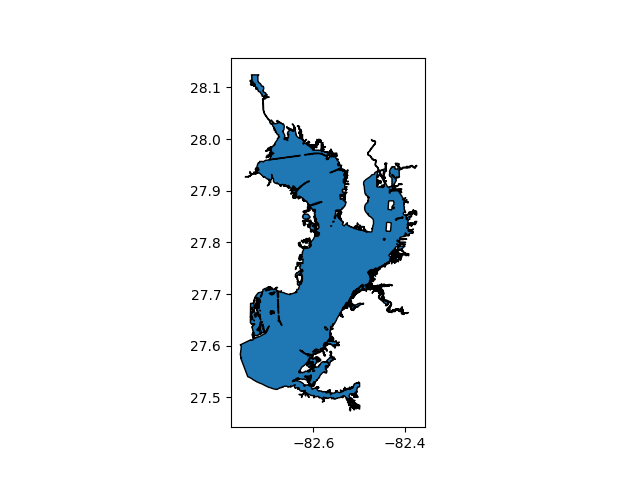

In [3]:
git_url = 'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data'
# Original source:
url_aoi = '{}/TampaBay.geojson'.format(git_url)
gdf_aoi = geopandas.read_file(url_aoi)
# Where to save outputs
data_dir = os.path.join(os.getcwd(), 'temperature_data')
# Transform to WGS84 since that is what H3 boundaries are converted to
gdf_aoi.to_crs(epsg=4326, inplace=True)
# Plot the AOI
gdf_aoi.plot(edgecolor='k')

Create a geodataframe with the hexagon boundaries

In [4]:
# Set the desired hexagon size (1-15)
hex_size = 7
hex_column = 'hex' + str(hex_size)
# Create data frame of hex ids of the set size that fill the aoi
aoi_hex_fill = poly_hex_idx(gdf_aoi, hex_size)
# To map these hexagons they need planar coordinates
aoi_hex_fill['geom'] = aoi_hex_fill[hex_column].apply(boundary_geom)
# The boundary coordinates can be used to create a geopandas dataframe
gdf_hex = geopandas.GeoDataFrame(aoi_hex_fill, geometry='geom')
gdf_hex = gdf_hex.set_crs(epsg=4326)  # Specify datum
# Project to get in meters
gdf_hex_prj = gdf_hex.to_crs(epsg=3747)
# Read out average area of hexagons at this scale (in decimal degrees)
print('Average km2 area for scale {}: {} (range: {} to {})'
      .format(hex_size,
              gdf_hex_prj['geom'].area.mean()*10**-6,
              gdf_hex_prj['geom'].area.min()*10**-6,
              gdf_hex_prj['geom'].area.max()*10**-6)
     )
# Note: smaller than global average units reported in Table 3

Average km2 area for scale 7: 4.826309807272184 (range: 4.807044271583679 to 4.843350351212357)


Plot the Tampa polygon filled with hexagons (use the interactive map to zoom in on small hexagons)

<IPython.core.display.Javascript object>


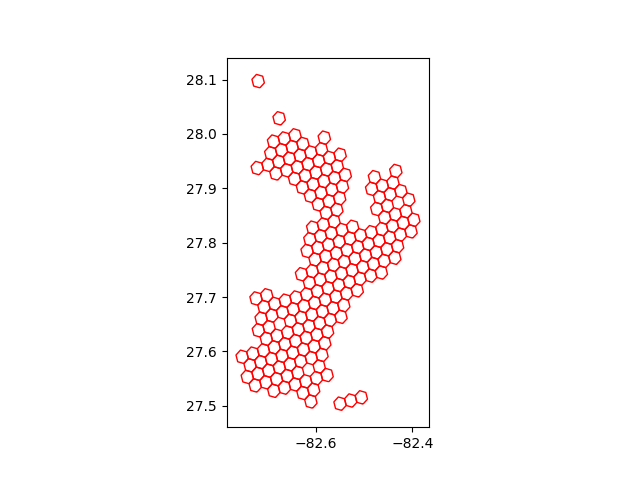

In [5]:
fig, ax = plt.subplots()
#ax=gdf_aoi.plot(edgecolor='k')
gdf_hex.plot(ax=ax, facecolor='none', edgecolor='red')

Geopandas can easily be saved as a shapefile (uncomment to save shape file)

In [6]:
#out_shp = os.path.join(data_dir, 'fill_{}.shp'.format(hex_column))
#gdf_hex.to_file(out_shp)

## Part 2: Load the example point data (downloads as two parts: points shp and csv data)

In [7]:
# Functions for Part 2
def wqp_stats(df, datetime_field, loc_field, statReportType='daily', statTypeCd='mean'):
    """
    NWIS-like daily statistics function for waterquality portal

    Parameters:
        statReportType (string): daily (default), monthly, or annual
        statTypeCd (string): all, mean, max, min, median

        Start and End will always be min/max timestamp in dataframe

    Returns:
        Dataframe of summary statistics
    """
    pd_freq = {'daily': 'D',
               'monthly': 'M',
               'annual': 'A'
               }
    if statReportType in pd_freq.keys():
        freq = pd_freq[statReportType]
    else:
        freq = statReportType

    # Resample by set increment
    if statTypeCd == 'all':
        print('WARNING: this has not been fully tested')
        mean_df = wqp_stats(df, datetime_field, loc_field, statReportType)
        max_df = wqp_stats(df, datetime_field, loc_field, statReportType, 'max')
        min_df = wqp_stats(df, datetime_field, loc_field, statReportType, 'min')
        median_df = wqp_stats(df, datetime_field, loc_field, statReportType, 'median')
        # Recombine with appropriate suffix
        keys = [loc_field, datetime_field]
        df1 = pandas.merge(mean_df, max_df, on=keys, suffixes=("_mean", "_max"))
        df2 = pandas.merge(min_df, median_df, on=keys, suffixes=("_min", "_median"))
        df = pandas.merge(df1, df2, on=keys)
    elif statTypeCd == 'mean':
        df = df.groupby(loc_field).resample(freq, on=datetime_field).mean()
    elif statTypeCd == 'max':
        df = df.groupby(loc_field).resample(freq, on=datetime_field).max()
    elif statTypeCd == 'min':
        df = df.groupby(loc_field).resample(freq, on=datetime_field).min()
    elif statTypeCd == 'median':
        df = df.groupby(loc_field).resample(freq, on=datetime_field).median()
    #else: statTypeCd error?
    return df.reset_index()


def hex_idx(gdf_in, hexagon_size, method='count'):
    """ Point to hex by aggregating"""
    gdf = gdf_in.copy(deep=True)
    h3_idx_col = 'hex' + str(hexagon_size)
    # Assign hex ID
    gdf[h3_idx_col] = gdf.apply(lambda x: h3.geo_to_h3(x.geometry.y,
                                                       x.geometry.x,
                                                       hexagon_size), 1)
    # Aggregate into hexagons
    if method == 'avg':
        pnt_hex = gdf.groupby(h3_idx_col).mean()
    else:
        pnt_hex = gdf.groupby(h3_idx_col).size().to_frame('cnt')
    return pnt_hex.reset_index()

In [8]:
# Read WQP query results from station points geojson and csv
# From WQP: https://www.waterqualitydata.us/portal/ (see getWQP notebook for query)
# Note these results were split to keep individual file sizes smaller
git_url = 'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data'
temp_loc = '{}/Temperature_Stations.geojson'.format(git_url)
temp_res = '{}/Temperature_Results.csv'.format(git_url)
gdf_temps = geopandas.read_file(temp_loc)  # Read to geodataframe
df_temps = pandas.read_csv(temp_res, low_memory=False)  # Read to dataframe

In [9]:
# Create geodataframe with just geometry
geom = gdf_temps[['MonitoringLocationIdentifier', 'geometry']]

In [10]:
# Join the tabular and spatial data
loc_ID = 'MonitoringLocationIdentifier'
gdf_temp = geom.set_index(loc_ID).join(df_temps.set_index(loc_ID))

In [11]:
# Recognize datetime fields
gdf_temp['Activity_datetime'] = pandas.to_datetime(gdf_temp['Activity_datetime'])
gdf_temp['Analysis_datetime'] = pandas.to_datetime(gdf_temp['Analysis_datetime'])
print('Date range: {} to {}'.format(min(gdf_temp['Activity_datetime']),
                                    max(gdf_temp['Activity_datetime'])))

Date range: 1995-01-04 14:01:00 to 2020-12-21 15:46:00


In [12]:
# Confirm unique sample sites in dataset
print('Sample sites in AOI: {}'.format(len(set(gdf_temp.reset_index()['MonitoringLocationIdentifier']))))
print('Temperature results at sites: {}'.format(len(gdf_temp)))

Sample sites in AOI: 9034
Temperature results at sites: 170161


Datetime fields can be used to get specific periods of time and average across set increments (e.g. average daily value from hourly data)

In [13]:
# Get daily averages
loc_ID = 'MonitoringLocationIdentifier'
df_day_all = wqp_stats(gdf_temp, 'Activity_datetime', loc_ID, statReportType='daily')
df_day_avg = df_day_all[df_day_all['deg_c'].notna()]
print('Days in range: {}'.format(len(df_day_all.groupby('Activity_datetime'))))
print('Daily results across sites: {}'.format(len(df_day_avg)))
print('Days with results at any site: {}'.format(len(df_day_avg.groupby('Activity_datetime'))))

Days in range: 9480
Daily results across sites: 54756
Days with results at any site: 3987


In [14]:
# Get annual averages
df_year_avg = wqp_stats(gdf_temp, 'Activity_datetime', loc_ID, statReportType='annual')
print('Years in range: {}'
      .format(len(df_year_avg.groupby('Activity_datetime').count())))
print('Annual results across sites: {}'
      .format(len(df_year_avg[df_year_avg['deg_c'].notna()])))
print('Locations with results in multiple years: {}'
      .format((df_year_avg.groupby(loc_ID)
               .count()['Activity_datetime'] == 1).sum()))
annual_counts = df_year_avg.groupby('Activity_datetime').count()['deg_c']
max_year_df = annual_counts[annual_counts == max(annual_counts)].reset_index()
max_year = max_year_df['Activity_datetime'][0].year
print('{} was the year with the most results, {}'
      .format(max_year, max_year_df['deg_c'][0]))
# Same as gdf_temp.groupby(loc_ID).resample('A', on='Activity_datetime').mean()

Years in range: 26
Annual results across sites: 14012
Locations with results in multiple years: 8296
2004 was the year with the most results, 883


In [15]:
# Limit to max year
df_max = df_year_avg[df_year_avg['Activity_datetime'] == max_year_df['Activity_datetime'][0]]
# Aggregate on geom to get stations for max year -?Already done
# station_max = df_max.groupby(loc_ID).count()

# Join back to geometry
gdf_max = df_max.set_index(loc_ID).join(geom.set_index(loc_ID))
#gdf_station_max = station_max.join(geom.set_index(loc_ID))

Aggregate point temperatures to hex

In [16]:
# Set the desired hexagon size (1-15)
hex_size = 7
hex_column = 'hex' + str(hex_size)
# Values within one hex can be aggregated multiple ways
station_hex = hex_idx(geom, hex_size)  # Count - stations
df_hex = hex_idx(gdf_temp, hex_size)  # Count - data points

In [17]:
# Max year - add average & count to table
# Aggregate on geom to get stations for max year
#station_max_hex = hex_idx(gdf_station_max, hex_size)  # Count - stations
hex_max_cnt = hex_idx(gdf_max, hex_size)  # Count - data points
hex_max = hex_idx(gdf_max, hex_size, 'avg')  # Average temperature
# Combine
hex_max = hex_max.set_index(hex_column).join(hex_max_cnt.set_index(hex_column))
hex_max = hex_max.reset_index()

In [18]:
# Print info from tables
# Stations - all years
print('All results:')
print('Number of stations per hexagon: {} to {}, {} average'
      .format(min(station_hex['cnt']),
              max(station_hex['cnt']),
              station_hex['cnt'].mean()))
print('There are {} hexagons with {} stations'
      .format(len(station_hex[station_hex['cnt'] == max(station_hex['cnt'])]),
              max(station_hex['cnt'])))
# Results - all years
print('Hexagons with temperature data: {}'.format(len(set(df_hex[hex_column]))))
# Results - max year
print('\nMax year results:')
print('Number of stations per hexagon: {} to {}, {} average'
      .format(min(hex_max['cnt']),
              max(hex_max['cnt']),
              hex_max['cnt'].mean()))
print('There are {} hexagons with {} stations'
      .format(len(hex_max[hex_max['cnt'] == max(hex_max['cnt'])]),
              max(hex_max['cnt'])))
print('Hexagons with temperature data: {}'.format(len(set(hex_max[hex_column]))))

All results:
Number of stations per hexagon: 1 to 758, 42.613207547169814 average
There are 1 hexagons with 758 stations
Hexagons with temperature data: 212

Max year results:
Number of stations per hexagon: 1 to 99, 5.761904761904762 average
There are 1 hexagons with 99 stations
Hexagons with temperature data: 168


Add geometry back to the dataframe to map it

In [19]:
# Add geometry to hexagon dataframes
station_hex['geom'] = station_hex[hex_column].apply(boundary_geom)
gdf_station_hex = geopandas.GeoDataFrame(station_hex, geometry='geom')

df_hex['geom'] = df_hex[hex_column].apply(boundary_geom)
gdf_hex = geopandas.GeoDataFrame(df_hex, geometry='geom')

# Annually averaged stations to hex
hex_max['geom'] = hex_max[hex_column].apply(boundary_geom)
gdf_max_hex = geopandas.GeoDataFrame(hex_max, geometry='geom')

<IPython.core.display.Javascript object>


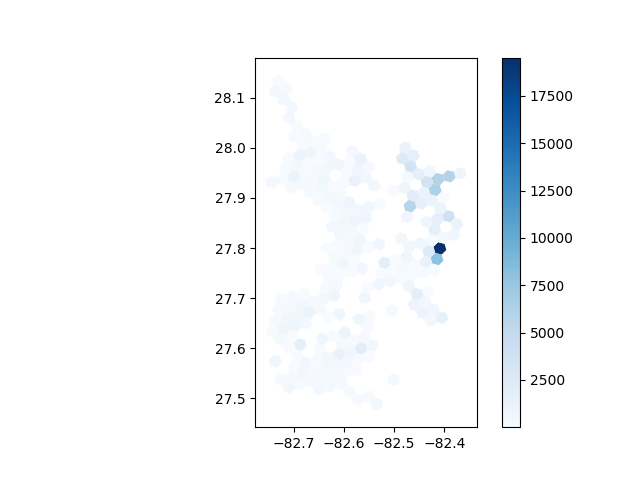

In [20]:
gdf_hex.plot(column='cnt', cmap='Blues', legend=True)

<IPython.core.display.Javascript object>


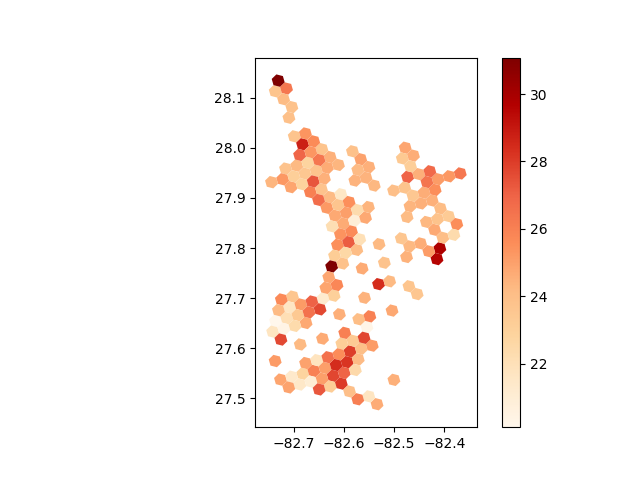

In [21]:
gdf_max_hex.plot(column='deg_c', cmap='OrRd', legend=True)

Geopandas can easily be saved as a shapefile (uncomment to save shape file)

In [22]:
# # All hexagons
# out_hex_stations_shp = os.path.join(data_dir, '{}_stations_all.shp'.format(hex_column))
# gdf_station_hex.dropna(axis=1, how='all', inplace=True)
# gdf_station_hex.to_file(out_hex_stations_shp)

# out_hex_shp = os.path.join(data_dir, '{}_avg_all.shp'.format(hex_column))
# gdf_hex.dropna(axis=1, how='all', inplace=True)
# gdf_hex.to_file(out_hex_shp)

# Max year
out_max_year_shp = os.path.join(data_dir, '{}_avg_{}.shp'.format(hex_column, max_year))
gdf_max_hex.dropna(axis=1, how='all', inplace=True)
gdf_max_hex.to_file(out_max_year_shp)

## Part 3: Interpolate areas where temperatures are missing

In [23]:
def kring_IDW(df_in, hex_col, metric_col, k_max):
    '''
    Uses hollow rings method, solid disks may be faster
    k_max is the number of rings out from a cell to consider
    '''
    df = df_in.copy(deep=True)

    df_agg = df[hex_col].to_frame()
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col, inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0

    for k in range(1, k_max):
        temp2.append((df_agg['hexk']
                      .apply(lambda x: pandas.Series(list(h3.hex_ring(x, k)))).stack()
                      .to_frame('hexk').reset_index(1, drop=True).reset_index()
                     ))
        temp2[-1]['k'] = k
    df_all = pandas.concat(temp2).merge(df)
    df_all.dropna(subset=[metric_col], inplace=True)  # Drop NaN
    # Instead of applying the coef, divide by k
    #df_all[metric_col] = df_all[metric_col] * df_all.k.apply(lambda x:coef[x])
    df_all['num_val'] = df_all[metric_col]/df_all.k  # if k=0, x/k = inf
    # sum numerator
    dfs_t = df_all.groupby('hexk')[['num_val']].sum()
    # sum denominator
    df_all['den_val'] = 1.0/df_all.k
    #nan -> inf so convert back and drop nan
    df_all['den_val'] = df_all['den_val'].replace(numpy.inf, numpy.nan)
    #df_all.dropna(subset=['num_val'], inplace=True)
    dfs_b = df_all.groupby('hexk')[['den_val']].sum()

    dfs = dfs_t.join(dfs_b)
    dfs['idw'] = dfs['num_val']/dfs['den_val']
    #reduce dfs
    dfs = dfs[['idw']]
    #fix index name
    dfs.index.rename(hex_col, inplace=True)
    #join back to df
    dfs = df.set_index(hex_col).join(dfs)
    #replace inf with orig?
    return dfs.reset_index()

If running part 3 independently re-define these variables

In [24]:
hex_size = 7
hex_column = 'hex' + str(hex_size)
# Original source:
url_aoi = '{}/TampaBay.geojson'.format(git_url)
gdf_aoi = geopandas.read_file(url_aoi)
gdf_aoi.to_crs(epsg=4326, inplace=True)  # Transform to WGS84
# Create filled area (define where temperatures are wanted)
aoi_hex_fill = poly_hex_idx(gdf_aoi, hex_size)

# Dataframe where temperatures are known (e.g. max year)
out_max_year_shp = os.path.join(data_dir, 'hex7_avg_2004.shp')
gdf_max_hex = geopandas.read_file(out_max_year_shp)

Combine aoi_hex_fill from part 1 and gdf_max_hex from part 2
NOTE: hex_size must be the same across these or there'll be a key error

In [25]:
# Combine hex data and filled hex
df_comb = aoi_hex_fill.set_index(hex_column).join(gdf_max_hex.set_index(hex_column))
df_comb.reset_index(inplace=True)

In [26]:
# Fill missing cells using IDW
df_max_idw = kring_IDW(df_comb, hex_column, metric_col='deg_c', k_max=20)
# Add geometry to hexagons to map
df_max_idw['geom'] = df_max_idw[hex_column].apply(boundary_geom)
gdf_max_idw = geopandas.GeoDataFrame(df_max_idw, geometry='geom')

<IPython.core.display.Javascript object>


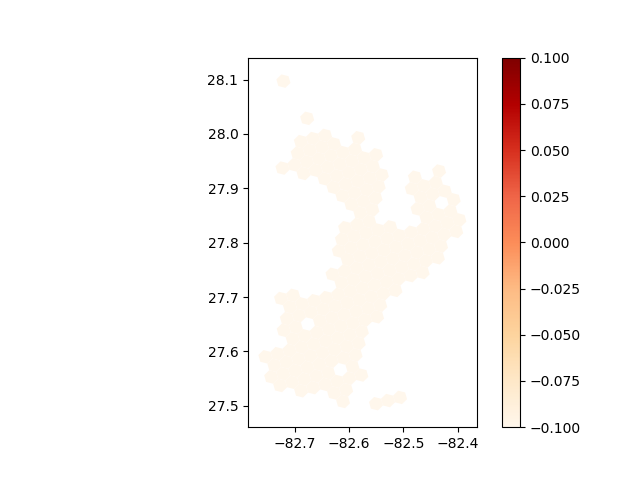

In [27]:
gdf_max_idw.plot(column='idw', cmap='OrRd', legend=True)

In [28]:
# Save interpolated surface
idw_hex_shp = os.path.join(data_dir, 'idw_7_2004_temp.shp')
gdf_max_idw.drop(columns=['USGSPCode', 'geometry'], inplace=True)
gdf_max_idw.to_file(idw_hex_shp)